## Final Project Submission

Please fill out:
* Student name: Matthew E. Parker
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL:

# Import libraries & Acquiring Data
First, import the necessary Python libraries and packages with which we will be working. Then, access the Kepler Telescope data using the Kepler API designed by NASA. 

Information about the Kepler Telescope API can be found at https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html

Information about the columns present in the "Objects of Interest" dataset can be found at https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

Information about the columns present in the "Confirmed Exoplanets" dataset can be found at https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html

In [145]:
# for acquiring and managing datasets
import requests
import pandas as pd
from io import StringIO

# for math
import numpy as np
np.random.seed(42)

# for graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# for modeling
from sklearn.feature_selection import SelectKBest, SelectFpr, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.decomposition import PCA

# classifier modeling methods
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [2]:
# Use the NASA's Kepler API to acquire telescope data
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative"
response = requests.get(url)
url2 = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets"
response2 = requests.get(url2)

In [3]:
# turn the API data into a usable format
data = StringIO(response.text)
df = pd.read_csv(data, index_col='kepoi_name')
data2 = StringIO(response2.text)
confirmed_planets_df = pd.read_csv(data2)

In [4]:
# adding additional parameters not included in the default dataset
url3 = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=kepoi_name,koi_smet,koi_smass"
response3 = requests.get(url3)
data3 = StringIO(response3.text)
df3 = pd.read_csv(data3, index_col='kepoi_name')
display(df3.head())
df3.info()

,koi_smet,koi_smass
kepoi_name,,
K00752.01,0.14,0.919
K00752.02,0.14,0.919
K00753.01,-0.18,0.961
K00754.01,-0.52,0.836
K00755.01,0.07,1.095


<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, K00752.01 to K07989.01
Data columns (total 2 columns):
koi_smet     9178 non-null float64
koi_smass    9201 non-null float64
dtypes: float64(2)
memory usage: 224.2+ KB


In [5]:
# merge the two datasets
df = pd.concat([df, df3], axis=1)

In [6]:
display(df.head())
df.info()

,kepid,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,...,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra_str,dec_str,koi_kepmag,koi_kepmag_err,koi_smet,koi_smass
kepoi_name,,,,,,,,,,,,,,,,,,,,,
K00752.01,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,...,-0.096,0.927,0.105,-0.061,19h27m44.22s,+48d08m29.9s,15.347,NaN,0.14,0.919
K00752.02,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,...,-0.096,0.927,0.105,-0.061,19h27m44.22s,+48d08m29.9s,15.347,NaN,0.14,0.919
K00753.01,10811496,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,...,-0.176,0.868,0.233,-0.078,19h48m01.16s,+48d08m02.9s,15.436,NaN,-0.18,0.961
K00754.01,10848459,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,...,-0.168,0.791,0.201,-0.067,19h02m08.31s,+48d17m06.8s,15.597,NaN,-0.52,0.836
K00755.01,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,...,-0.210,1.046,0.334,-0.133,19h15m01.17s,+48d13m34.3s,15.509,NaN,0.07,1.095


<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, K00752.01 to K07989.01
Data columns (total 51 columns):
kepid                9564 non-null int64
kepler_name          2305 non-null object
koi_disposition      9564 non-null object
koi_pdisposition     9564 non-null object
koi_score            8054 non-null float64
koi_fpflag_nt        9564 non-null int64
koi_fpflag_ss        9564 non-null int64
koi_fpflag_co        9564 non-null int64
koi_fpflag_ec        9564 non-null int64
koi_period           9564 non-null float64
koi_period_err1      9110 non-null float64
koi_period_err2      9110 non-null float64
koi_time0bk          9564 non-null float64
koi_time0bk_err1     9110 non-null float64
koi_time0bk_err2     9110 non-null float64
koi_impact           9201 non-null float64
koi_impact_err1      9110 non-null float64
koi_impact_err2      9110 non-null float64
koi_duration         9564 non-null float64
koi_duration_err1    9110 non-null float64
koi_duration_err2    9110 non-null flo

# Scrub the data

In [7]:
# remove columns with no data
df.drop(['koi_teq_err1', 'koi_teq_err2','koi_kepmag_err'], axis=1, inplace=True)

In [8]:
# condensed data, dropping error columns and non-data columns for simplicity of this project
errors = ['koi_period_err1','koi_period_err2','koi_time0bk_err1','koi_time0bk_err2',
          'koi_impact_err1','koi_impact_err2','koi_duration_err1','koi_duration_err2',
          'koi_depth_err1','koi_depth_err2','koi_prad_err1','koi_prad_err2',
          'koi_insol_err1','koi_insol_err2','koi_steff_err1','koi_steff_err2',
          'koi_slogg_err1','koi_slogg_err2','koi_srad_err1','koi_srad_err2']
descriptors = ['kepid','kepler_name','koi_disposition','koi_score',
               'koi_tce_delivname','ra_str','dec_str']
df_descriptors = df[['kepid','kepler_name','koi_disposition','koi_score','koi_tce_delivname','ra_str','dec_str']]

df_original = df.copy() #creating a backup copy in case its needed later
df = df.drop(errors, axis=1)
df = df.drop(descriptors, axis=1)

In [10]:
# drop rows containing NaN values
df.dropna(inplace=True)

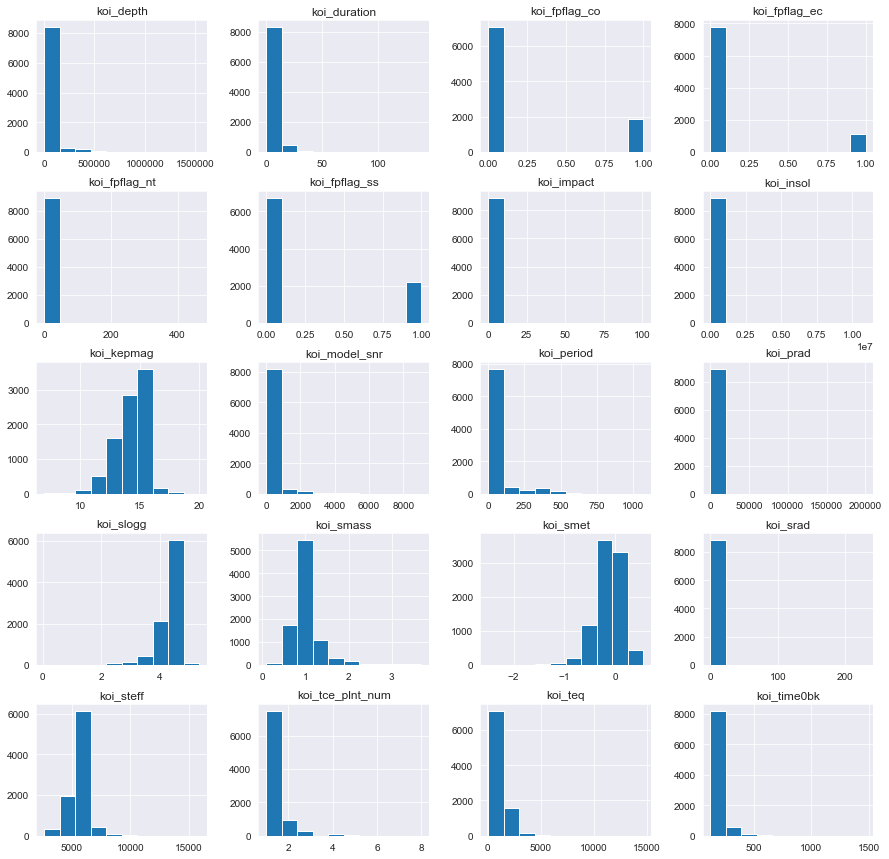

In [11]:
# examine the distributions for each variable
df.hist(figsize=(15,15));

**It looks like there are probably some outliers or other peculiar values in the data. Let's explore these, then get rid of outliers.**

In [12]:
continuous_data = ['koi_period','koi_time0bk','koi_impact','koi_duration','koi_depth',
                   'koi_prad','koi_teq','koi_insol','koi_model_snr','koi_steff','koi_srad']

In [13]:
new_df = df.copy()

# removing outliers and peculiar data
indexNames = new_df[
#                     (new_df['koi_depth'] >= 4000) |
#                     (new_df['koi_duration'] >= 30) |
                    (new_df['koi_fpflag_nt'] >= 200) |
                    (new_df['koi_impact'] >= 1.5) |
                    (new_df['koi_insol'] >= 4500) |
                    (new_df['koi_model_snr'] >= 3000) |
#                     (new_df['koi_period'] >= 600) |
#                     (new_df['koi_prad'] >= 50) |
#                     (new_df['koi_smet'] < -1.25) |
#                     (new_df['koi_srad'] > 4) |
                    (new_df['koi_steff'] >= 10000) |
                    (new_df['koi_teq'] >= 10000) |
                    (new_df['koi_time0bk'] >= 1000)].index
new_df.drop(indexNames, inplace=True)

print(len(new_df))

7820


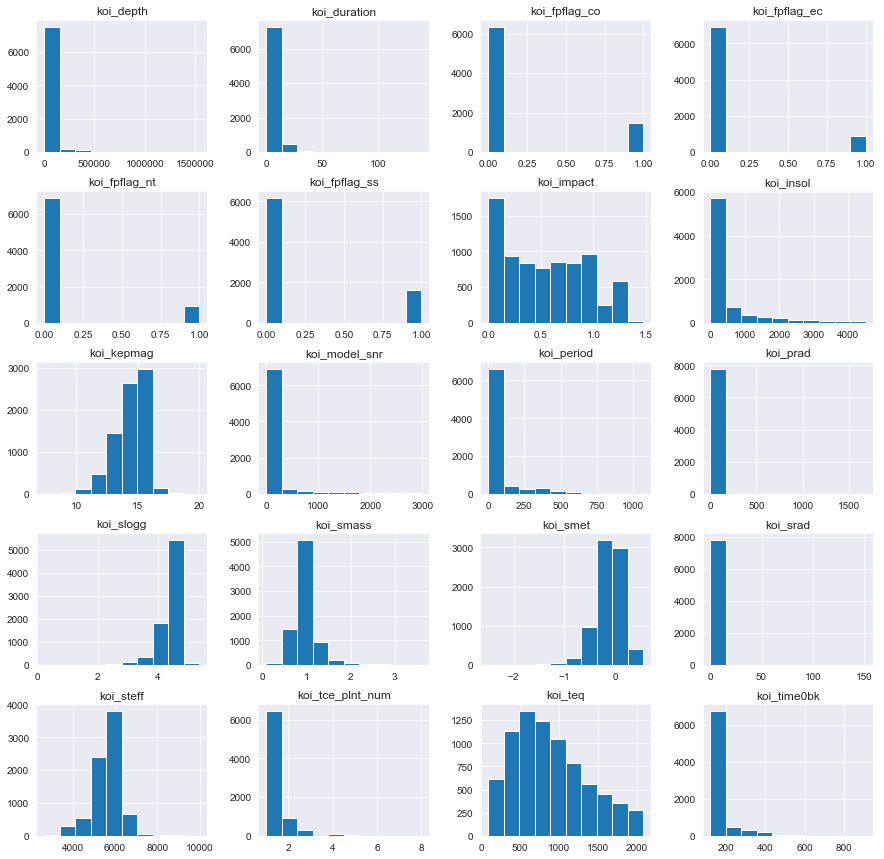

In [14]:
new_df.hist(figsize=(15,15));

**Though our elimination of NaNs and outliers reduced our dataset by over 15%, we still have over 7,800 observations, which should be more than enough to build a model.**

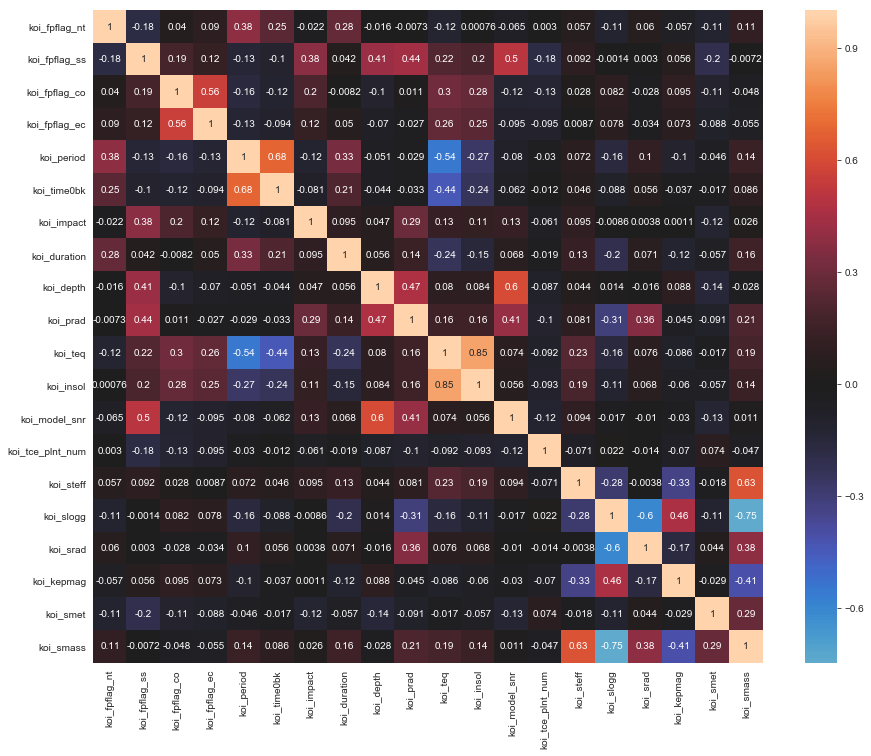

In [15]:
# look for multicollinearity
corr = new_df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, center=0, annot=True);

It seems there are a few instances of high multicollinearity in your dataset. Looking back to the Kepler API information website, it seems that `koi_teq` and `koi_insol` are two measures of the same thing (surface temperature), so we can safely remove one of those. It also seems that `koi_period` and `koi_time0bk` measure similar things, so we'll also drop one of those. 

We will also drop `koi_tce_plnt_num`, `koi_fpflag_nt`, `koi_fpflag_ss`, `koi_fpflag_co`, and `koi_fpflag_ec` since they are the results of analyis, not observations themselves.

In [16]:
new_df.drop(columns=['koi_insol','koi_time0bk','koi_tce_plnt_num', 'koi_fpflag_nt', 
                     'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'], inplace=True)

The other multicollinear variables (`koi_steff`, `koi_slogg`, `koi_srad`, with `koi_smass` and `koi_period` with `koi_teq`) will be kept. Although they are very correlated, each one sounds like it could be an impactful measure in its own right. There are other instances of less severe multicollinearity (correlation score < |.6| ), but we will have to address these and the other multicollinear features we kept through weighting and feature engineering.



### Scaling the data & Encoding labels

In [17]:
# log transforming non-linear data
non_normal = ['koi_depth', 'koi_duration', 'koi_period','koi_prad','koi_srad']
for feat in non_normal:
    new_df[feat] = new_df[feat].map(lambda x: np.log(x))

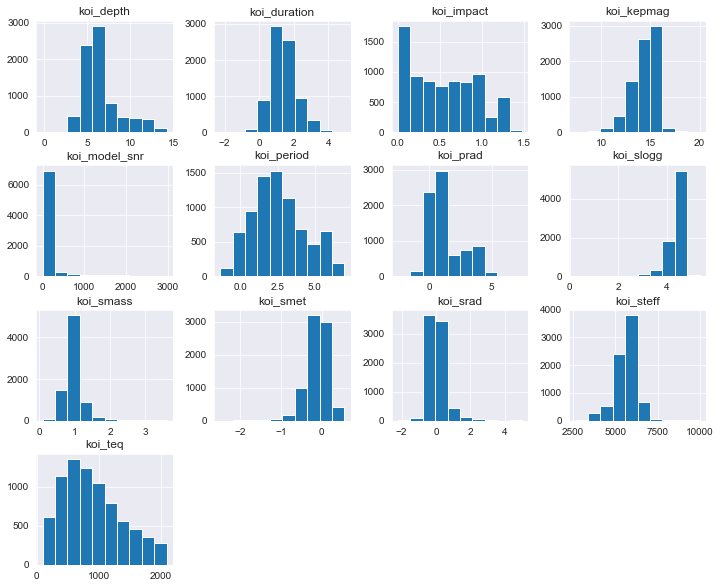

In [18]:
new_df.hist(figsize=(12,10));

In [19]:
target = new_df.koi_pdisposition
variables = new_df.drop('koi_pdisposition', axis=1)

In [20]:
target.index

Index(['K00752.01', 'K00752.02', 'K00753.01', 'K00754.01', 'K00755.01',
       'K00756.01', 'K00756.02', 'K00756.03', 'K00114.01', 'K00757.01',
       ...
       'K08193.01', 'K08194.01', 'K08195.01', 'K08196.01', 'K08197.01',
       'K08198.01', 'K07984.01', 'K07986.01', 'K07988.01', 'K07989.01'],
      dtype='object', name='kepoi_name', length=7820)

In [21]:
# encoding labels
le = LabelEncoder()
labels = pd.DataFrame(le.fit_transform(target), columns=['koi_pdisposition'], index=target.index)

In [22]:
# scaling features
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(variables), columns=variables.columns, index=target.index)

# Exploring the Data

In [23]:
features.describe()

,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_kepmag,koi_smet,koi_smass
count,7.820000e+03,7.820000e+03,7.820000e+03,7.820000e+03,7.820000e+03,7.820000e+03,7820.000000,7.820000e+03,7.820000e+03,7.820000e+03,7.820000e+03,7820.000000,7.820000e+03
mean,4.361388e-17,-3.271041e-16,3.925249e-16,1.163037e-16,1.308416e-16,6.542081e-17,0.000000,4.070628e-16,2.973013e-15,7.268979e-18,-7.378014e-16,0.000000,1.744555e-16
std,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064,1.000064e+00
min,-2.235175e+00,-1.387498e+00,-4.892578e+00,-3.131651e+00,-2.750559e+00,-1.695353e+00,-0.385076,-4.279421e+00,-1.252464e+01,-4.632684e+00,-5.441800e+00,-8.546004,-3.133280e+00
25%,-7.240489e-01,-9.301358e-01,-6.514571e-01,-6.499241e-01,-6.946065e-01,-7.895496e-01,-0.357269,-5.047743e-01,-2.368914e-01,-5.194491e-01,-5.991998e-01,-0.517571,-5.296015e-01
50%,-1.106520e-01,-5.591356e-02,-9.608884e-02,-2.397586e-01,-3.384864e-01,-1.744459e-01,-0.333434,1.383029e-01,2.660097e-01,-1.637397e-01,1.978212e-01,0.127571,-6.656702e-02
75%,6.262664e-01,8.506968e-01,5.635666e-01,2.591560e-01,5.396783e-01,6.476233e-01,-0.234941,6.238623e-01,5.568440e-01,2.924698e-01,7.498436e-01,0.665189,3.394786e-01
max,2.485491e+00,2.411509e+00,4.707420e+00,3.555437e+00,4.434824e+00,2.511366e+00,6.582127,6.288722e+00,3.010759e+00,1.018634e+01,4.336438e+00,2.421409,9.357966e+00


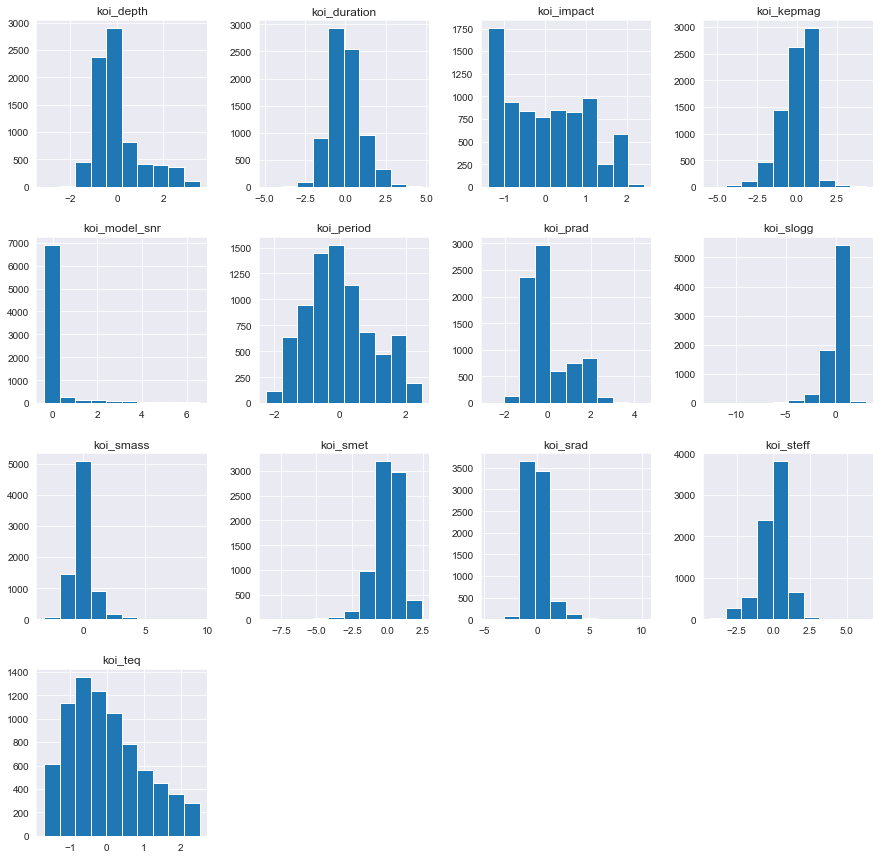

In [24]:
features.hist(figsize=(15,15));

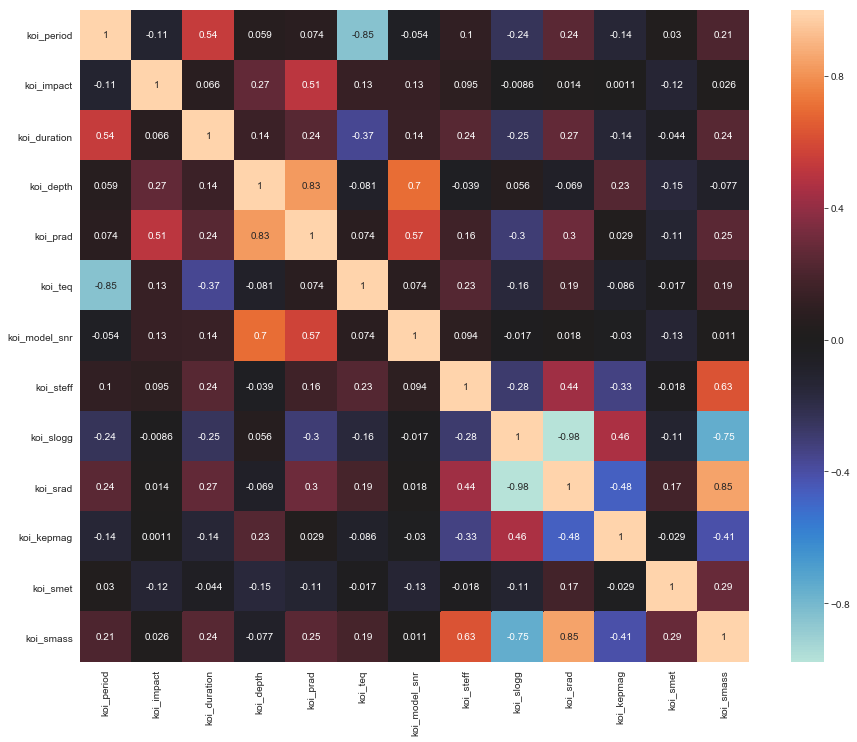

In [25]:
# look at correlation heatmap
corr = features.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, center=0, annot=True);

### Handling multicollinearity

Let's engineer a few features to try to reduce some of the extreme multicollinearity seen in the heatmap above.

In [26]:
features_orig = features.copy()   #just in case
features['target'] = labels.koi_pdisposition.values
features.head()

,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_kepmag,koi_smet,koi_smass,target
kepoi_name,,,,,,,,,,,,,,
K00752.01,-0.194890,-1.011460,-0.429677,-0.060560,-0.338486,-0.218683,-0.301421,-0.241763,0.293275,-0.248149,0.726584,0.916078,-0.194792,0
K00752.02,0.795633,0.121803,0.132917,0.101668,-0.176113,-0.955965,-0.324789,-0.241763,0.293275,-0.248149,0.726584,0.916078,-0.194792,0
K00753.01,0.225124,1.108257,-1.106060,1.264285,1.008408,-0.545193,-0.206784,0.333394,0.526549,-0.382847,0.795587,-0.230841,-0.045196,0
K00754.01,-1.157756,1.898965,-0.705051,1.128923,1.607135,1.049442,0.796376,0.264028,0.587139,-0.573119,0.920412,-1.449443,-0.490422,1
K00755.01,-0.945469,0.417996,-1.205347,-0.070036,-0.196816,1.072614,-0.289504,0.590625,0.205419,-0.000770,0.852185,0.665189,0.432086,0


In [27]:
def feature_builder(var_1, var_2, target, dataset):
    """
    Parameters :
    ------------
    var_1 : column name of first potentially correlated variable
    var_2 : column name of second potentially correlated variable
    target : column name of target variable
    dataset : name of pandas DataFrame that holds data and will receive updates
    """
    weights = np.linspace(0, 1, 10000)
    max_corr = -1
    best_weights = None
    corrs = []

    for index, weight in enumerate(weights):
        w1 = weight       # get the first weight value
        w2 = 1 - weight   # get the second weight value
        vals = w1*dataset[var_1] + w2*dataset[var_2] # create a linear combination of the columns
        corr_coeff = np.abs(np.corrcoef(vals, dataset[target]))[0][1] # get the corrcoeff with the target

        # if the corr_coeff is larger than the max, store the weights and change the max
        if corr_coeff > max_corr:
            best_weights = [w1, w2]
            max_corr = corr_coeff

        # store the correlation coefficients to a list
        corrs.append(corr_coeff)  
    
    # output the desired weights
    print('weight for [',var_1,'] : weight for [',var_2,']\n', best_weights)
    feat_label = str(var_1+'_'+var_2+'_feat')
    print('feature name : ', feat_label)
    
    # add feature to dataset & remove input columns
    dataset[feat_label] = w1*dataset[var_1] + w2*dataset[var_2]
    dataset.drop([var_1, var_2], axis=1, inplace=True)
    pass

In [28]:
features = features_orig.copy()
features['target'] = labels.koi_pdisposition.values

In [ ]:
# first, let's drop two features which seem to have 
# exorbitantly high multicollinearity with other features
features.drop()

In [29]:
feature_builder('koi_teq','koi_period','target',features)

weight for [ koi_teq ] : weight for [ koi_period ]
 [0.6356635663566357, 0.3643364336433643]
feature name :  koi_teq_koi_period_feat


In [30]:
feature_builder('koi_srad','koi_smass','target',features)

weight for [ koi_srad ] : weight for [ koi_smass ]
 [0.547954795479548, 0.45204520452045205]
feature name :  koi_srad_koi_smass_feat


In [31]:
feature_builder('koi_prad','koi_model_snr','target',features)

weight for [ koi_prad ] : weight for [ koi_model_snr ]
 [0.8147814781478148, 0.18521852185218524]
feature name :  koi_prad_koi_model_snr_feat


In [32]:
feature_builder('koi_slogg','koi_srad_koi_smass_feat','target',features)

weight for [ koi_slogg ] : weight for [ koi_srad_koi_smass_feat ]
 [1.0, 0.0]
feature name :  koi_slogg_koi_srad_koi_smass_feat_feat


In [33]:
feature_builder('koi_prad_koi_model_snr_feat','koi_depth','target',features)

weight for [ koi_prad_koi_model_snr_feat ] : weight for [ koi_depth ]
 [1.0, 0.0]
feature name :  koi_prad_koi_model_snr_feat_koi_depth_feat


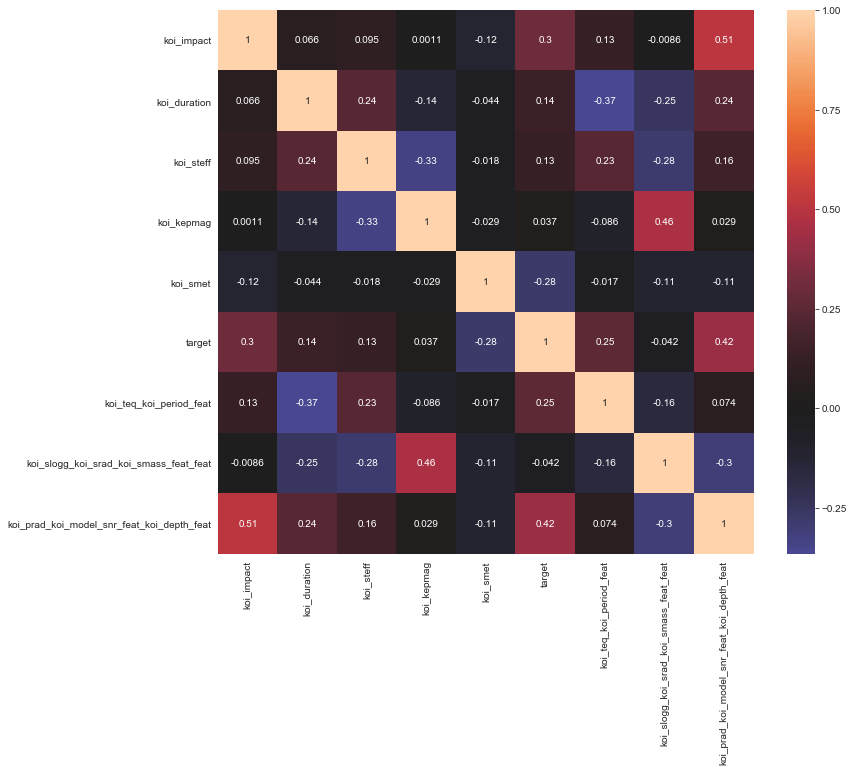

In [34]:
# look at correlation heatmap
corr = features.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, center=0, annot=True);

In [35]:
features.drop(['target'], axis=1, inplace=True)

In [36]:
features.columns

Index(['koi_impact', 'koi_duration', 'koi_steff', 'koi_kepmag', 'koi_smet',
       'koi_teq_koi_period_feat', 'koi_slogg_koi_srad_koi_smass_feat_feat',
       'koi_prad_koi_model_snr_feat_koi_depth_feat'],
      dtype='object')

In [37]:
features.columns = ['koi_impact', 'koi_duration', 'koi_steff', 'koi_kepmag',
                    'koi_smet', 'teq_period_feat', 'slogg_srad_smass_feat',
                    'prad_modelsnr_depth_feat']

In [38]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7820 entries, K00752.01 to K07989.01
Data columns (total 8 columns):
koi_impact                  7820 non-null float64
koi_duration                7820 non-null float64
koi_steff                   7820 non-null float64
koi_kepmag                  7820 non-null float64
koi_smet                    7820 non-null float64
teq_period_feat             7820 non-null float64
slogg_srad_smass_feat       7820 non-null float64
prad_modelsnr_depth_feat    7820 non-null float64
dtypes: float64(8)
memory usage: 549.8+ KB


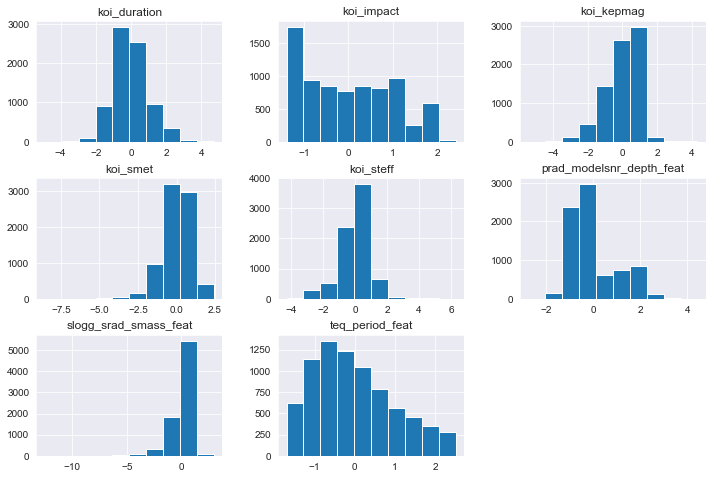

In [44]:
features.hist(figsize=(12,8));

In [179]:
# define a function to generate a confusion matrix
def confu_matrix(alg, x_tst, y_tst):
    y_pred = alg.predict(x_tst)
    cm = confusion_matrix(y_tst, y_pred)
    sns.heatmap(cm, annot=True, fmt='0g', annot_kws={'size':14, 'ha':'center', 'va':'top'})
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='0.01%', annot_kws={'size':14, 'ha':'center', 'va':'bottom'})
    plt.title('Confusion Matrix')
    plt.show();

Number of mislabeled points out of a total points : 1732
22.15 %


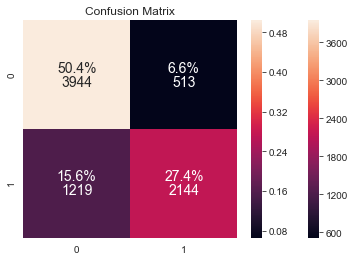

In [180]:
# very simple test model with Guassian Naive Bayes
gnb = GaussianNB()
y_pred = gnb.fit(features, labels.koi_pdisposition.values).predict(features)
print(f"Number of mislabeled points out of a total points : {(labels.koi_pdisposition.values != y_pred).sum()}")
print(round(1732/len(labels),4)*100,"%")
confu_matrix(gnb, features, labels)

# Modeling the data

### Train, test, split

In [186]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

### Trying XGBoost without PCA

In [187]:
# create a function to automate model fitting and visualizing feature importance
def modelfit(alg, x_tr, y_tr, x_tst, y_tst, n_estims=1000, early_stopping_rounds=10):
#     xgb_param = alg.get_xgb_params()
#     xgtrain = xgboost.DMatrix(x_tr, label=y_tr)
#     cvresult = xgboost.cv(xgb_param, xgtrain,
#                       num_boost_round=n_estims,
#                       nfold=5, metrics='auc',
#                       early_stopping_rounds=early_stopping_rounds)
#     alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    eval_set = [(x_tst, y_tst)]
    alg.fit(x_tr, y_tr, eval_metric='auc', eval_set=eval_set, early_stopping_rounds=10)
    
    #Predict training set:
    dtrain_predictions = alg.predict(x_tr)
    dtrain_predprob = alg.predict_proba(x_tr)[:,1]
    #Predict testing set:
    dtest_predictions = alg.predict(x_tst)
    dtest_predprob = alg.predict_proba(x_tst)[:,1]
    
    #Print model report:
    print("Model Report")
    print(f"Train Accuracy: {round(metrics.accuracy_score(y_tr, dtrain_predictions), 4)*100}%")
    print(f"Test Accuracy: {round(metrics.accuracy_score(y_tst, dtest_predictions), 4)*100}%")
    print(f"AUC Score (Train): {metrics.roc_auc_score(y_tr, dtrain_predprob)}")
    print(f"AUC Score (Test): {metrics.roc_auc_score(y_tst, dtest_predprob)}")
    
    # plotting feature importances
    feat_imp = pd.Series(alg.get_booster()\
                         .get_score(importance_type='weight'))\
                         .sort_values(ascending=False)
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    # plotting confusion matrix
    plt.subplot(122)
    confu_matrix(alg, x_tst, y_tst);

[0]	validation_0-auc:0.799243
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.828089
[2]	validation_0-auc:0.828198
[3]	validation_0-auc:0.833644
[4]	validation_0-auc:0.8353
[5]	validation_0-auc:0.836008
[6]	validation_0-auc:0.836997
[7]	validation_0-auc:0.838288
[8]	validation_0-auc:0.842137
[9]	validation_0-auc:0.841121
[10]	validation_0-auc:0.845711
[11]	validation_0-auc:0.845498
[12]	validation_0-auc:0.849874
[13]	validation_0-auc:0.84895
[14]	validation_0-auc:0.859527
[15]	validation_0-auc:0.862725
[16]	validation_0-auc:0.861158
[17]	validation_0-auc:0.863144
[18]	validation_0-auc:0.864679
[19]	validation_0-auc:0.865379
[20]	validation_0-auc:0.866451
[21]	validation_0-auc:0.865905
[22]	validation_0-auc:0.867122
[23]	validation_0-auc:0.867256
[24]	validation_0-auc:0.869069
[25]	validation_0-auc:0.868958
[26]	validation_0-auc:0.869087
[27]	validation_0-auc:0.869401
[28]	validation_0-auc:0.870762
[29]	validation_0-auc:0.870792
[30]	validation_0-a

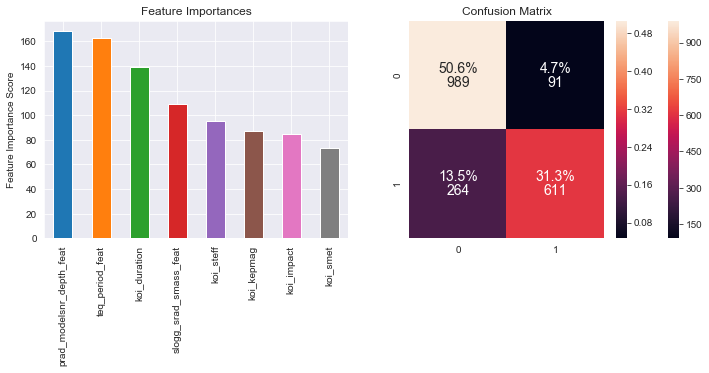

In [202]:
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=42)
modelfit(xgb1, X_train, y_train.koi_pdisposition.values,
         X_test, y_test.koi_pdisposition.values, 1000, 10)

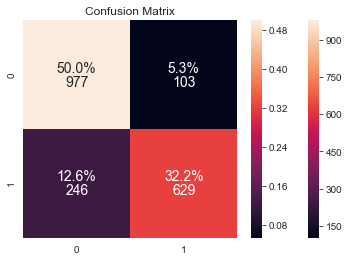

Train Accuracy: 93.84%
Test Accuracy: 82.15%


({'max_depth': 7, 'min_child_weight': 2}, 0.8279618082872882)

In [198]:
# Tuning max_depth and min_child_weight
param_test1 = {'max_depth':range(3,10), 
               'min_child_weight':range(1,6)
              }
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=128, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=42), 
                        param_grid=param_test1, scoring='accuracy',
                        n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train, y_train.koi_pdisposition.values, early_stopping_rounds=10, 
             eval_metric='auc', eval_set=[(X_test, y_test.koi_pdisposition.values)],
             verbose=False)
confu_matrix(gsearch1, X_test, y_test)
print(f"Train Accuracy: {round(metrics.accuracy_score(y_train.koi_pdisposition.values,gsearch1.predict(X_train)), 4)*100}%")
print(f"Test Accuracy: {round(metrics.accuracy_score(y_test.koi_pdisposition.values, gsearch1.predict(X_test)), 4)*100}%")
print(gsearch1.best_params_, gsearch1.best_score_)

**Now we have our optimal `max_depth` (7) and `min_child_weight` (2) values. Let's move on to some other parameters.**

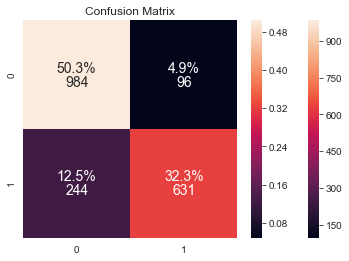

Model Report
Train Accuracy: 92.86%
Test Accuracy: 82.61%


({'colsample_bytree': 0.75, 'gamma': 0.1, 'subsample': 0.75},
 0.828640040459303)

In [197]:
# tuning gamma, subsample, and colsample_bytree    
param_test2 = {'gamma':[i/10.0 for i in range(0,3)],
               'subsample':[i/100 for i in range(75,90,5)],
               'colsample_bytree':[i/100 for i in range(65,90,5)] }
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=128, 
                                                  max_depth=7, 
                                                  min_child_weight=2, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=42), 
                        param_grid=param_test2, scoring='accuracy',
                        n_jobs=4, iid=False, cv=5)
gsearch2.fit(X_train, y_train.koi_pdisposition.values, early_stopping_rounds=10, 
             eval_metric='auc', eval_set=[(X_test, y_test.koi_pdisposition.values)],
             verbose=False)
confu_matrix(gsearch2, X_test, y_test)
print(f"Train Accuracy: {round(metrics.accuracy_score(y_train.koi_pdisposition.values,gsearch2.predict(X_train)), 4)*100}%")
print(f"Test Accuracy: {round(metrics.accuracy_score(y_test.koi_pdisposition.values, gsearch2.predict(X_test)), 4)*100}%")
print(gsearch2.best_params_, gsearch2.best_score_)

**Now we have the ideal `gamma` (0.1), `subsample` (.75) and `colsample_bytree` (.75) values.**

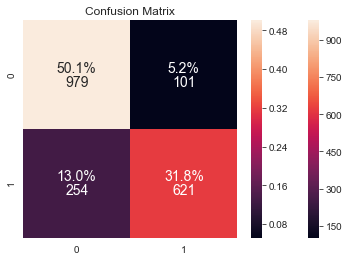

({'reg_alpha': 0.05, 'reg_lambda': 1}, 0.828640040459303)

In [192]:
# tuning reg_alpha and reg_lambda    
param_test3 = {'reg_alpha': [0, .05, .1],
               'reg_lambda': [.8, .9, 1],
              }
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=128,
                                                  max_depth=7,
                                                  min_child_weight=2,
                                                  gamma=0.1,
                                                  subsample=0.75,
                                                  colsample_bytree=0.75,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=42), 
                        param_grid=param_test3, scoring='accuracy',
                        n_jobs=4, iid=False, cv=5)
gsearch3.fit(X_train, y_train.koi_pdisposition.values, early_stopping_rounds=10, 
             eval_metric='auc', eval_set=[(X_test, y_test.koi_pdisposition.values)],
             verbose=False)
confu_matrix(gsearch3, X_test, y_test)
print(f"Train Accuracy: {round(metrics.accuracy_score(y_train.koi_pdisposition.values,gsearch3.predict(X_train)), 4)*100}%")
print(f"Test Accuracy: {round(metrics.accuracy_score(y_test.koi_pdisposition.values, gsearch3.predict(X_test)), 4)*100}%")
print(gsearch3.best_params_, gsearch2.best_score_)

**Now we have the ideal `reg_alpha` (0.05) and `reg_lambda` (1) values.**
Now to reduce the learning rate and recalculate the number of trees/estimators we should use.

[0]	validation_0-auc:0.842195
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.867109
[2]	validation_0-auc:0.875897
[3]	validation_0-auc:0.877708
[4]	validation_0-auc:0.878268
[5]	validation_0-auc:0.881916
[6]	validation_0-auc:0.884319
[7]	validation_0-auc:0.883499
[8]	validation_0-auc:0.884962
[9]	validation_0-auc:0.885496
[10]	validation_0-auc:0.886124
[11]	validation_0-auc:0.886342
[12]	validation_0-auc:0.887241
[13]	validation_0-auc:0.88858
[14]	validation_0-auc:0.88884
[15]	validation_0-auc:0.88871
[16]	validation_0-auc:0.888868
[17]	validation_0-auc:0.889099
[18]	validation_0-auc:0.889078
[19]	validation_0-auc:0.889226
[20]	validation_0-auc:0.889008
[21]	validation_0-auc:0.889294
[22]	validation_0-auc:0.890488
[23]	validation_0-auc:0.890977
[24]	validation_0-auc:0.891502
[25]	validation_0-auc:0.891553
[26]	validation_0-auc:0.891856
[27]	validation_0-auc:0.891661
[28]	validation_0-auc:0.892012
[29]	validation_0-auc:0.892077
[30]	validation_0-a

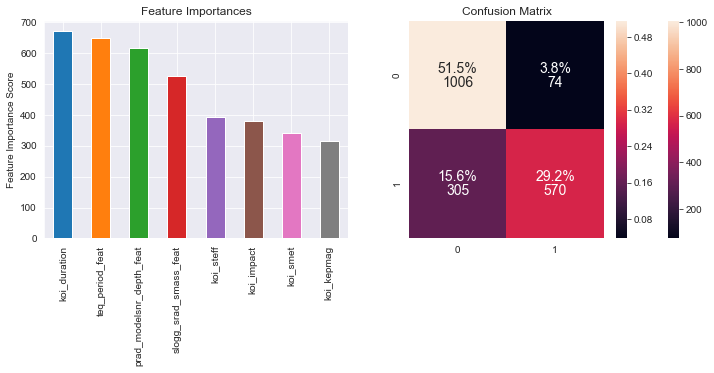

In [193]:
# instantiating a model with the ideal hyperparamters
xgb2 = XGBClassifier(learning_rate=0.01,
                     n_estimators=1000,
                     max_depth=7,
                     min_child_weight=2,
                     gamma=0.1,
                     subsample=0.75,
                     colsample_bytree=0.75,
                     reg_alpha=0.05,
                     reg_lambda=1,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=42)
modelfit(xgb2, X_train, y_train.koi_pdisposition.values,
         X_test, y_test.koi_pdisposition.values, 1000)

In [117]:
# instantiating a model with the ideal hyperparamters
xgb3 = XGBClassifier(learning_rate=0.01, n_estimators=57, max_depth=6, 
                     min_child_weight=4, gamma=0, subsample=0.85, seed=42,
                     colsample_bytree=0.75, reg_alpha=0.1, reg_lambda=0.9, 
                     objective= 'binary:logistic', nthread=4, scale_pos_weight=1)

# How is ***this*** the best test accuracy I've gotten?!?!

## Principal Component Analysis

First, we need to determine how many engineered features are required in order to explain at least 95% of the variance in the dataset. We can do this using Principal Component Analysis.

7

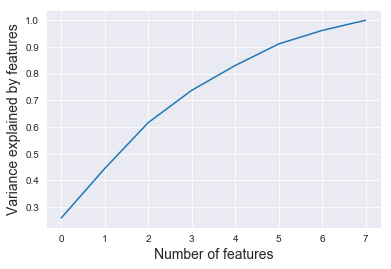

In [134]:
# perfrom Principal Component Analysis to determine how many features
# will explain 95% of model variance
pca = PCA()
features_pca = pca.fit_transform(features)
variance = pca.explained_variance_ratio_.cumsum()
plt.plot(range(features_pca.shape[1]), variance)
plt.xlabel("Number of features", fontsize=14)
plt.ylabel("Variance explained by features", fontsize=14);

n_features = len(variance[variance <= .95]) + 1
n_features

**So it looks like using 7 features will explain 95% of the variance in our data.**

In [135]:
# train, test, split PCA data for future models
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, random_state=42)

### Compare classification methods

In [136]:
classifiers = [KNeighborsClassifier, SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, XGBClassifier]

In [137]:
classy_scores = []
for classifier in classifiers:
    clf = classifier()
    clf.fit(X_train, y_train.koi_pdisposition.values)
    score = clf.score(X_test, y_test.koi_pdisposition.values)
    classy_scores.append((str(classifier), score))
ranked_classifiers = sorted(classy_scores, key=lambda x: x[1], reverse=True)

ranked_classifiers

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[("<class 'sklearn.svm.classes.SVC'>", 0.8173913043478261),
 ("<class 'xgboost.sklearn.XGBClassifier'>", 0.8081841432225064),
 ("<class 'sklearn.neighbors.classification.KNeighborsClassifier'>",
  0.8035805626598466),
 ("<class 'sklearn.ensemble.forest.RandomForestClassifier'>",
  0.7969309462915601),
 ("<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>",
  0.7836317135549872),
 ("<class 'sklearn.tree.tree.DecisionTreeClassifier'>", 0.7503836317135549)]

**It appears that the most promising methods are XGBoost and Support Vector Classification.**

### Begin tuning parameters for XGBoost

Many thanks to this site: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ for providing a walkthrough to tuning XGBoost parameters.

Train Score: 0.8429667519181586
Test Score: 0.810230179028133


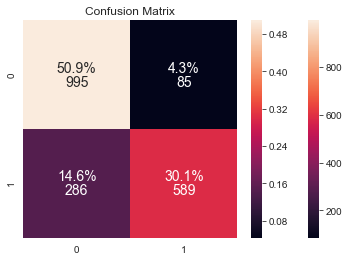

In [184]:
# building a model with default parameters
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4,
                    random_state=42, objective='binary:logistic')
xgb_params = {}
clf_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy')
clf_xgb.fit(X_train, y_train.koi_pdisposition.values, early_stopping_rounds=10,
            eval_metric='auc', eval_set=[(X_test, y_test.koi_pdisposition.values)],
            verbose=False)
print('Train Score:', clf_xgb.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_xgb.score(X_test,y_test.koi_pdisposition.values))

confu_matrix(clf_xgb, X_test, y_test.koi_pdisposition.values)

In [159]:
y_pred

array([0, 0, 1, ..., 1, 1, 0])

Train Score: 0.8702472293265132
Test Score: 0.8112531969309463

Best max_depth: 6
Best min_child_weight: 9


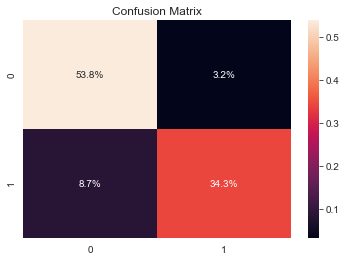

In [147]:
# Tuning max_depth, min_child_weight
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4, 
                    random_state=42, objective='binary:logistic')
xgb_params = {'max_depth': range(4, 7),
              'min_child_weight': range(2, 11),
             }
clf_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy')
clf_xgb.fit(X_train, y_train.koi_pdisposition.values, early_stopping_rounds=10,
            eval_metric='auc', eval_set=[(X_test, y_test.koi_pdisposition.values)],
            verbose=False)
print('Train Score:', clf_xgb.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_xgb.score(X_test,y_test.koi_pdisposition.values))
print('\nBest max_depth:', clf_xgb.best_estimator_.get_params()['max_depth'])
print('Best min_child_weight:', clf_xgb.best_estimator_.get_params()['min_child_weight'])

confu_matrix(clf_xgb, X_test, y_test.koi_pdisposition.values)

Train Score: 0.8861040068201194
Test Score: 0.8179028132992328

Best max_depth: 6
Best min_child_weight: 9
Best gamma: 0.2
Best subsample: 0.8
Best col_sample_bytree: 0.75


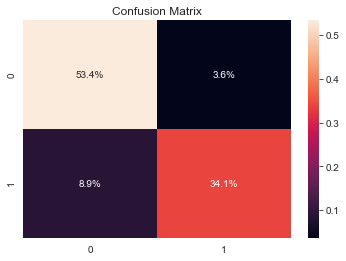

In [148]:
# Tuning gamma, subsample, and col_sample_bytree
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4, random_state=42, 
                    objective='binary:logistic', max_depth=6, min_child_weight=9)
xgb_params = {'gamma': [0, .1, .2],
              'subsample':[i/100 for i in range(75,101,5)],
              'col_sample_bytree':[i/100 for i in range(75,101,5)] 
             }
clf_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy')
clf_xgb.fit(X_train, y_train.koi_pdisposition.values, early_stopping_rounds=10,
            eval_metric='auc', eval_set=[(X_test, y_test.koi_pdisposition.values)],
            verbose=False)
print('Train Score:', clf_xgb.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_xgb.score(X_test,y_test.koi_pdisposition.values))

print('\nBest max_depth:', clf_xgb.best_estimator_.get_params()['max_depth'])
print('Best min_child_weight:', clf_xgb.best_estimator_.get_params()['min_child_weight'])
print('Best gamma:', clf_xgb.best_estimator_.get_params()['gamma'])
print('Best subsample:', clf_xgb.best_estimator_.get_params()['subsample'])
print('Best col_sample_bytree:', clf_xgb.best_estimator_.get_params()['col_sample_bytree'])

confu_matrix(clf_xgb, X_test, y_test.koi_pdisposition.values)

Train Score: 0.8861040068201194
Test Score: 0.8179028132992328

Best max_depth: 6
Best min_child_weight: 9
Best gamma: 0.2
Best reg_alpha: 0
Best reg_lambda: 1


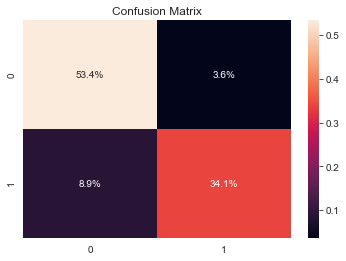

In [149]:
# Tuning reg_alpha and reg_lambda
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4, random_state=42,
                    objective='binary:logistic', max_depth=6, min_child_weight=9,
                    gamma=0.2, subsample=0.8, col_sample_bytree=0.75)
xgb_params = {'reg_alpha': [0, .05, .1],
              'reg_lambda': [.8, .9, 1],
             }
clf_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy')
clf_xgb.fit(X_train, y_train.koi_pdisposition.values, early_stopping_rounds=10,
            eval_metric='auc', eval_set=[(X_test, y_test.koi_pdisposition.values)],
            verbose=False)
print('Train Score:', clf_xgb.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_xgb.score(X_test,y_test.koi_pdisposition.values))

print('\nBest max_depth:', clf_xgb.best_estimator_.get_params()['max_depth'])
print('Best min_child_weight:', clf_xgb.best_estimator_.get_params()['min_child_weight'])
print('Best gamma:', clf_xgb.best_estimator_.get_params()['gamma'])
print('Best reg_alpha:', clf_xgb.best_estimator_.get_params()['reg_alpha'])
print('Best reg_lambda:', clf_xgb.best_estimator_.get_params()['reg_lambda'])

confu_matrix(clf_xgb, X_test, y_test.koi_pdisposition.values)

Train Score: 0.8861040068201194
Test Score: 0.8179028132992328


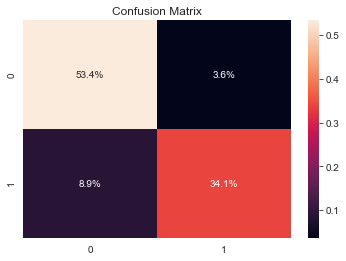

In [150]:
# instantiating classifier with best parameters
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4, subsample=.8,
                    col_sample_bytree=.75, random_state=42, objective='binary:logistic',
                    max_depth=6, min_child_weight=9, gamma=0.2, reg_alpha=0, reg_lambda=1)
xgb_params = {}
clf_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy')
clf_xgb.fit(X_train, y_train.koi_pdisposition.values, early_stopping_rounds=10,
            eval_metric='auc', eval_set=[(X_test, y_test.koi_pdisposition.values)],
            verbose=False)
print('Train Score:', clf_xgb.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_xgb.score(X_test,y_test.koi_pdisposition.values))

confu_matrix(clf_xgb, X_test, y_test.koi_pdisposition.values)

So, now we know that our best XGBoost parameters are:
    - learning_rate=0.1
    - n_estimators=100
    - nthread=4
    - subsample=.8
    - col_sample_bytree=.75
    - random_state=42
    - objective='binary:logistic'
    - max_depth=6
    - min_child_weight=9
    - gamma=0.2
    - reg_alpha=0
    - reg_lambda=.9
    
`xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4, subsample=.8, col_sample_bytree=.75, random_state=42, objective='binary:logistic', max_depth=6, min_child_weight=9, gamma=0.2, reg_alpha=0, reg_lambda=.9)`

### Begin tuning parameters for SVM

Train Score: 0.8485933503836317
Test Score: 0.8173913043478261


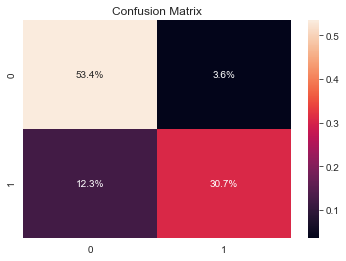

In [155]:
# building a model with default parameters, testing two different kernels
svc = SVC(random_state=42)
svc_params = {'gamma':['auto']}

clf_svc = GridSearchCV(svc, svc_params, cv=5, scoring='accuracy')
clf_svc.fit(X_train, y_train.koi_pdisposition.values)
print('Train Score:', clf_svc.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_svc.score(X_test,y_test.koi_pdisposition.values))

confu_matrix(clf_svc, X_test, y_test.koi_pdisposition.values)

Train Score: 0.8465473145780051
Test Score: 0.8225063938618926

Best kernel: rbf
Best C: 1
Best class_weight: balanced
Best gamma: auto


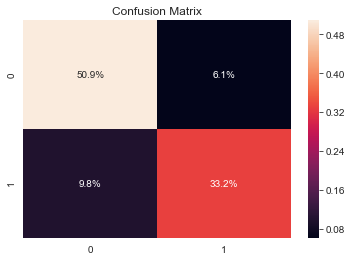

In [156]:
# tuning hyperparameters
svc = SVC(random_state=42)
svc_params = {'kernel': ['linear','rbf'],
              'C': [.1, 1, 10],
              'class_weight': [None,'balanced'],
              'gamma': ['auto','scale']
             }
clf_svc = GridSearchCV(svc, svc_params, cv=5, scoring='accuracy')
clf_svc.fit(X_train, y_train.koi_pdisposition.values)
print('Train Score:', clf_svc.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_svc.score(X_test,y_test.koi_pdisposition.values))
print('\nBest kernel:', clf_svc.best_estimator_.get_params()['kernel'])
print('Best C:', clf_svc.best_estimator_.get_params()['C'])
print('Best class_weight:', clf_svc.best_estimator_.get_params()['class_weight'])
print('Best gamma:', clf_svc.best_estimator_.get_params()['gamma'])

confu_matrix(clf_svc, X_test, y_test.koi_pdisposition.values)

In [158]:
# instantiating classifier with best parameters
svc = SVC(kernel='rbf', C=1, class_weight='balanced', gamma='auto', random_state=42)
svc_params = {}
clf_svc = GridSearchCV(svc, svc_params, cv=5, scoring='accuracy')

**Only marginal improvement, but still better nonetheless.** Thus, our ideal parameters for SVC are:
    - kernel='rbf'
    - C=1
    - class_weight='balanced'
    - gamma='auto'
`svc = SVC(kernel='rbf', C=1, class_weight='balanced', gamma='auto', random_state=42)`

## Use Stacking

Here's some articles on it:
    - https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/
    - http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

In [379]:
def Stacking(model, train, test, y, n_fold):
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    folds = StratifiedKFold(n_splits=n_fold, random_state=42)
    test_pred = np.empty((0,1), float)
    train_pred = np.empty((0,1), float)
    for train_indices, val_indices in folds.split(train, y.values):
        x_tr, x_val = train.iloc[train_indices], train.iloc[val_indices]
        y_tr, y_val = y.iloc[train_indices], y.iloc[val_indices]
        model.fit(x_tr, y_tr)
        train_pred = np.append(train_pred, model.predict(x_val))
    test_pred = np.append(test_pred, model.predict(test))
    return test_pred, train_pred

In [380]:
#base model 1 (XGBoostClassifier)
model1 = clf_xgb

test_pred1, train_pred1 = Stacking(model=model1, n_fold=10, train=X_train,
                                   test=X_test, y=y_train.koi_pdisposition)

train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)

In [381]:
#base model 2 (SVC)
model2 = clf_svc

test_pred2, train_pred2 = Stacking(model=model2, n_fold=10, train=X_train,
                                   test=X_test, y=y_train.koi_pdisposition)

train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

In [382]:
# stacking a new model (LogisticRegression) on top of the two bases
df_stack = pd.concat([train_pred1, train_pred2], axis=1)
df_stack.columns = ['xgb','svc']

df_stack_train = pd.concat([train_pred1, train_pred2], axis=1)
df_stack_train.columns = ['xgb','svc']
df_stack_test = pd.concat([test_pred1, test_pred2], axis=1)
df_stack_test.columns = ['xgb','svc']

model_stack = LogisticRegression(solver='lbfgs')
model_stack.fit(df_stack, y_train.koi_pdisposition)

print('Train Score:', model_stack.score(df_stack_train, y_train.koi_pdisposition))
print('Test Score:', model_stack.score(df_stack_test, y_test.koi_pdisposition))

Train Score: 0.796078431372549
Test Score: 0.8225063938618926


In [383]:
# tuning stacked model hyperparameters
stack_params = {'C': [1, 10],
                'class_weight': [None, 'balanced'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
               }
clf_stack = GridSearchCV(model_stack, stack_params, cv=5)
clf_stack.fit(df_stack, y_train.koi_pdisposition.values)
print('Train Score:', clf_stack.score(df_stack_train, y_train.koi_pdisposition))
print('Test Score:', clf_stack.score(df_stack_test, y_test.koi_pdisposition))
print('Best C:', clf_stack.best_estimator_.get_params()['C'])
print('Best class_weight:', clf_stack.best_estimator_.get_params()['class_weight'])
print('Best solver:', clf_stack.best_estimator_.get_params()['solver'])

Train Score: 0.796078431372549
Test Score: 0.8184143222506394
Best C: 1
Best class_weight: balanced
Best solver: newton-cg


## Sigh...

Oddly, the model performs better on the test dataset than it does on the train dataset. At least the scores are pretty close together.

In [400]:
clf_stack_train_predproba = clf_stack.predict_proba(df_stack_train)[:,1]
print(f"AUC Score (Train): {metrics.roc_auc_score(y_train, clf_stack_train_predproba)}")
clf_stack_test_predproba = clf_stack.predict_proba(df_stack_test)[:,1]
print(f"AUC Score (Test): {metrics.roc_auc_score(y_test, clf_stack_test_predproba)}")

AUC Score (Train): 0.8053378752807672
AUC Score (Test): 0.8309121693121693
